In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from postdocsalary.paths import DATA_DIR, ensure_dir
import urllib.request

<ipython-input-2-37777429a894>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from postdocsalary.paths import save_fig, FIGURE_DIR

### Home prices

In [31]:
regions = [
    "Boston city",
    "New York County",
    "Cook County",
    "Allegheny County",
    "San Diego County",
    "San Francisco County",
    #"Baltimore County",
    #"Multnomah County",
    "Harris County",
    #"Washtenaw County",
    #"Durham County"
]

In [77]:
cba_subs = [
    "METRO41740M41740",
    "METRO41860MM7360",
    "METRO16980M16980",
    "METRO14460MM1120",
    "METRO35620MM5600",
    "METRO38300M38300",
    #"METRO20500M20500",
    #"METRO38900M38900",
    #"METRO11460M11460",
    #"METRO38900M38900",
    "METRO26420M26420",
    #"METRO12580M12580"
]

In [78]:
file = DATA_DIR / 'rent' / "FMR_2Bed_1983_2022_2.csv"

home_prices = pd.read_csv(file,encoding='latin1')

In [79]:
for sub in cba_subs:
    print(sub, home_prices[home_prices.msa22 == sub].areaname22.values[0])

METRO41740M41740 San Diego-Carlsbad, CA MSA
METRO41860MM7360 San Francisco, CA HUD Metro FMR Area
METRO16980M16980 Chicago-Joliet-Naperville, IL HUD Metro FMR Area
METRO14460MM1120 Boston-Cambridge-Quincy, MA-NH HUD Metro FMR Area
METRO35620MM5600 New York, NY HUD Metro FMR Area
METRO38300M38300 Pittsburgh, PA HUD Metro FMR Area
METRO26420M26420 Houston-The Woodlands-Sugar Land, TX HUD Metro FMR Area


In [57]:
home_prices[:3]

,fips2010,fips2000,areaname22,name,msa22,fmr22_2,fmr22,msa21,fmr21_2,fmr21,...,fmr83,cbsasub,areaname,state,cousub,county,pop2010,census_region,pop2017,pop2000
0,100199999,100199999.0,"Montgomery, AL MSA",Autauga County,METRO33860M33860,914,40,METRO33860M33860,908,40,...,45.0,METRO33860M33860,"Montgomery, AL MSA",1.0,99999.0,1.0,54571,3.0,55035,43671.0
1,100399999,100399999.0,"Daphne-Fairhope-Foley, AL MSA",Baldwin County,METRO19300M19300,1017,40,METRO19300M19300,922,40,...,45.0,METRO19300M19300,"Daphne-Fairhope-Foley, AL MSA",1.0,99999.0,3.0,182265,3.0,203360,140415.0
2,100599999,100599999.0,"Barbour County, AL",Barbour County,NCNTY01005N01005,705,40,NCNTY01005N01005,648,40,...,45.0,NCNTY01005N01005,"Barbour County, AL",1.0,99999.0,5.0,27457,3.0,26200,29038.0


In [58]:
def get_year(x):
    year = x.split('_')[0][-2:]
    if int(year) < 80:
        year = int("20"+year)
    else:
        year = int("19"+year)
    return year

In [59]:
# melt for year
home_prices_all_melt = home_prices.melt(id_vars="areaname22", value_vars = home_prices.columns[4:-7])
home_prices_all = home_prices_all_melt[np.array([i[-2:] == '_2' for i in home_prices_all_melt.variable.values])]
home_prices_all['Year'] = [get_year(i) for i in home_prices_all.variable.values]
home_prices_all[:3]

<ipython-input-59-078faac182e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_prices_all['Year'] = [get_year(i) for i in home_prices_all.variable.values]


,areaname22,variable,value,Year
4765,"Montgomery, AL MSA",fmr22_2,914,2022
4766,"Daphne-Fairhope-Foley, AL MSA",fmr22_2,1017,2022
4767,"Barbour County, AL",fmr22_2,705,2022


In [60]:
home_prices_all = home_prices_all.merge(home_prices[['pop2000', 'areaname22']], on="areaname22")

In [61]:
year_mean = {
    year: np.nanmean(home_prices_all[home_prices_all.Year == year].value.values.astype(float))
    for year in home_prices_all.Year.unique()
}

In [62]:
home_prices_regions = home_prices[home_prices.name.isin(regions)]
home_prices_regions = home_prices_regions[home_prices_regions.cbsasub.isin(cba_subs)]
# melt for year
home_prices_regions_melt = home_prices_regions.melt(
    id_vars="areaname22", value_vars=home_prices_regions.columns[4:-7]
)
home_prices_regions = home_prices_regions_melt[
    np.array([i[-2:] == "_2" for i in home_prices_regions_melt.variable.values])
]
home_prices_regions["Year"] = [get_year(i) for i in home_prices_regions.variable.values]
home_prices_regions["relative_price"] = [
    row.value / year_mean[row.Year] for idx, row in home_prices_regions.iterrows()
]
home_prices_regions

<ipython-input-62-ae14d8424f2a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_prices_regions["Year"] = [get_year(i) for i in home_prices_regions.variable.values]
<ipython-input-62-ae14d8424f2a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_prices_regions["relative_price"] = [


,areaname22,variable,value,Year,relative_price
7,"San Diego-Carlsbad, CA MSA",fmr22_2,1979,2022,1.534985
8,"San Francisco, CA HUD Metro FMR Area",fmr22_2,3198,2022,2.480486
9,"Chicago-Joliet-Naperville, IL HUD Metro FMR Area",fmr22_2,1340,2022,1.039353
10,"Boston-Cambridge-Quincy, MA-NH HUD Metro FMR Area",fmr22_2,2205,2022,1.710279
11,"New York, NY HUD Metro FMR Area",fmr22_2,2026,2022,1.571440
...,...,...,...,...,...
807,"Chicago-Joliet-Naperville, IL HUD Metro FMR Area",fmr83_2,498.0,1983,1.243053
808,"Boston-Cambridge-Quincy, MA-NH HUD Metro FMR Area",fmr83_2,515.0,1983,1.285487
809,"New York, NY HUD Metro FMR Area",fmr83_2,420.0,1983,1.048358
810,"Pittsburgh, PA HUD Metro FMR Area",fmr83_2,372.0,1983,0.928546


In [63]:
region_dict = {
    "San Diego-Carlsbad, CA MSA": (
        0.17254901960784313,
        0.6274509803921569,
        0.17254901960784313,
    ),
    "San Francisco, CA HUD Metro FMR Area": (
        0.8392156862745098,
        0.15294117647058825,
        0.1568627450980392,
    ),
    "Chicago-Joliet-Naperville, IL HUD Metro FMR Area": (
        0.5803921568627451,
        0.403921568627451,
        0.7411764705882353,
    ),
    "Baltimore-Columbia-Towson, MD MSA": (
        0.8901960784313725,
        0.4666666666666667,
        0.7607843137254902,
    ),
    "Boston-Cambridge-Quincy, MA-NH HUD Metro FMR Area": (
        0.12156862745098039,
        0.4666666666666667,
        0.7058823529411765,
    ),
    "Ann Arbor, MI MSA": (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
    "New York, NY HUD Metro FMR Area": (1.0, 0.4980392156862745, 0.054901960784313725),
    "Durham-Chapel Hill, NC HUD Metro FMR Area": (
        0.6823529411764706,
        0.7803921568627451,
        0.9098039215686274,
    ),
    "Portland-Vancouver-Hillsboro, OR-WA MSA": (
        0.4980392156862745,
        0.4980392156862745,
        0.4980392156862745,
    ),
    "Pittsburgh, PA HUD Metro FMR Area": (
        0.5490196078431373,
        0.33725490196078434,
        0.29411764705882354,
    ),
    "Houston-The Woodlands-Sugar Land, TX HUD Metro FMR Area": (
        0.7372549019607844,
        0.7411764705882353,
        0.13333333333333333,
    ),
}

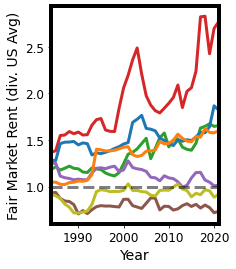

In [64]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(3, 4))
sns.lineplot(
    data=home_prices_regions,
    x="Year",
    y="relative_price",
    hue="areaname22",
    ax=ax,
    lw=3,
    palette=region_dict,
    legend=False
)
#ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax.set_xlim([1984, 2021])
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel("Fair Market Rent (div. US Avg)", fontsize=14)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
ax.spines['right'].set_linewidth(4)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.axhline(1, ls = 'dashed', lw=3, alpha = 0.5, color = 'k')


save_fig(FIGURE_DIR / 'fair-market-rent-relative')

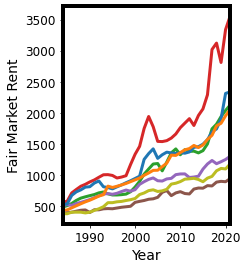

In [65]:
fig, ax = plt.subplots(figsize=(3, 4))
sns.lineplot(
    data=home_prices_regions, x="Year", y="value", hue="areaname22", ax=ax,
    lw=3,
    palette=region_dict,
    legend=False
)
#ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax.set_xlim([1984, 2021])
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel("Fair Market Rent", fontsize=14)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
ax.spines['right'].set_linewidth(4)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
save_fig(FIGURE_DIR / 'fair-market-rent')

### Fair market rent in 2021 dollars

In [66]:
home_prices_regions.columns = ['MSA', 'var', "price", "year", "relative_price"]

In [67]:
from datetime import date

In [68]:
import cpi

In [69]:
home_prices_regions[:3]

,MSA,var,price,year,relative_price
7,"San Diego-Carlsbad, CA MSA",fmr22_2,1979,2022,1.534985
8,"San Francisco, CA HUD Metro FMR Area",fmr22_2,3198,2022,2.480486
9,"Chicago-Joliet-Naperville, IL HUD Metro FMR Area",fmr22_2,1340,2022,1.039353


In [70]:
inflation_adjusted_price = []
for idx, row in home_prices_regions.iterrows():
    dollars_2021 = cpi.inflate(
        row.price,
        year_or_month=date(np.min([2021, row.year]), 1, 1),
        to=date(2021, 1, 1),
    )
    inflation_adjusted_price.append(dollars_2021)

In [71]:
home_prices_regions['inflation_adjusted_price_2021'] = inflation_adjusted_price

<ipython-input-71-50a0403df1e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_prices_regions['inflation_adjusted_price_2021'] = inflation_adjusted_price


In [72]:
home_prices_regions[:3]

,MSA,var,price,year,relative_price,inflation_adjusted_price_2021
7,"San Diego-Carlsbad, CA MSA",fmr22_2,1979,2022,1.534985,1979.0
8,"San Francisco, CA HUD Metro FMR Area",fmr22_2,3198,2022,2.480486,3198.0
9,"Chicago-Joliet-Naperville, IL HUD Metro FMR Area",fmr22_2,1340,2022,1.039353,1340.0


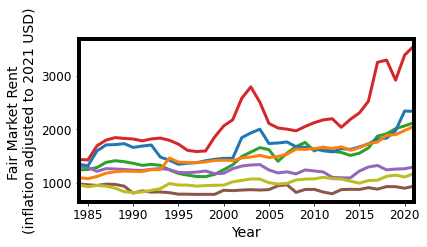

In [73]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.lineplot(
    data=home_prices_regions,
    x="year",
    y="inflation_adjusted_price_2021",
    hue="MSA",
    ax=ax,
    lw=3,
    palette=region_dict,
    legend=False
)
#ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax.set_xlim([1984, 2021])
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel("Fair Market Rent \n(inflation adjusted to 2021 USD)", fontsize=14)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
ax.spines['right'].set_linewidth(4)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
#ax.axhline(1, ls = 'dashed', lw=3, alpha = 0.5, color = 'k')


save_fig(FIGURE_DIR / 'fair-market-rent-inflation-adjusted')

In [80]:
home_prices_regions[:3]

,MSA,var,price,year,relative_price,inflation_adjusted_price_2021
7,"San Diego-Carlsbad, CA MSA",fmr22_2,1979,2022,1.534985,1979.0
8,"San Francisco, CA HUD Metro FMR Area",fmr22_2,3198,2022,2.480486,3198.0
9,"Chicago-Joliet-Naperville, IL HUD Metro FMR Area",fmr22_2,1340,2022,1.039353,1340.0


In [87]:
home_prices_regions[(home_prices_regions["MSA"] == "San Francisco, CA HUD Metro FMR Area")
                   # & (home_prices_regions["year"].isin([1985,2021]))
                   ]

,MSA,var,price,year,relative_price,inflation_adjusted_price_2021
8,"San Francisco, CA HUD Metro FMR Area",fmr22_2,3198,2022,2.480486,3198.000000
29,"San Francisco, CA HUD Metro FMR Area",fmr21_2,3553,2021,2.769139,3553.000000
50,"San Francisco, CA HUD Metro FMR Area",fmr20_2,3339,2020,2.697759,3385.738312
71,"San Francisco, CA HUD Metro FMR Area",fmr19_2,2809,2019,2.426190,2919.145047
92,"San Francisco, CA HUD Metro FMR Area",fmr18_2,3121,2018,2.829081,3293.691464
113,"San Francisco, CA HUD Metro FMR Area",fmr17_2,3018,2017,2.822758,3250.937765
134,"San Francisco, CA HUD Metro FMR Area",fmr16_2,2289.0,2016,2.238517,2527.314314
155,"San Francisco, CA HUD Metro FMR Area",fmr15_2,2062.0,2015,2.061699,2307.941499
176,"San Francisco, CA HUD Metro FMR Area",fmr14_2,1956.0,2014,2.021940,2187.342431
197,"San Francisco, CA HUD Metro FMR Area",fmr13_2,1795.0,2013,1.848274,2038.994659
